# 0. Введение

Техника сглаживания оказала достаточно большое влияние на развитие методов восстановления тензоров (matrix completion problem является частным случаем). 

Рассмотрим задачу восстановления матрицы $Y$. Мы наблюдаем только небольшой набор элементов матрицы $Y$, множество индексов известных элементов обозначим через $E$. То есть мы знаем $Y_{ij}$ для всех $(i,j) \in E$, и не знаем $Y_{ij}$ для всех $(i,j) \notin E$.

Понятно, что без наличия какой-либо дополнительной информации о матрице $Y$ эта постановка является тривиальной: любая матрица $X$, для которой выполнено $X_{i,j} = Y_{i,j}, \quad (i,j) \in E$ является разумным ответом. Таких матриц бесконечно много. Соответственно задача восстановления матриц обычно рассматривается как частный случай задачи приближения матрицы, а критерий качества (целевая функция) говорит не столько о близости $X$ к $Y$, сколько о полезных свойствах матрицы $X$ (этим свойствам матрица $Y$ может и не обладать).

Одна из самых популярных постановок, например, строя рекомендательные системы, является задача о поиске наилучшего приближения заданной матрицы матрицей малого ранга:

$$
\begin{align*}
& \min_{X} rk(X) \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$
Как известно, в общем случае эта задача является NP-трудной.

Для того, чтобы обойти это припятствие ранк матрицы аппроксимируется той или иной выпуклой функцией от матрицы $X$.

Опять же стандартным выбором является переход к постановке задачи с использованием 1-й нормы Шаттена (она же trace norm).

$\textbf{RegMC problem}$

$$
\begin{align*}
& \min_{X}\|X \|_* \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$

Здесь $X_* = \sum \sigma_i(X)$. 

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

#  1. Сведение к ADMM

Сведём нашу задачу пригодную для решения алгоритмом ADMM(Правила восстановления, через модифицированную функцию Лагранжа):
$$ \min_{X}\|X \|_* $$
$$  X_{i,j} = Y_{i,j}, (i,j) \in E, X_* = \sum \sigma_i(X) $$
Заведём индикаторную функцию на множестве матриц, таком, что $X_{i,j} = Y_{i,j}, (i,j) \in E$, т.е множестве: $S=\{X | X_{i,j} = Y_{i,j}, (i,j) \in E\}$. Тогда наша задача будет выглядить следующим образом:
$$\min_{X=Z} \|X \|_* + I_S(Z)$$
Данную задачу мы можем решить алгоритмом ADMM

#  2. Метод модифицированной функции Лагранжа

Надо решить задачу со следующими ограничениями:
$$\begin{cases}
f(x) \rightarrow min \\
f_{i}(x) \leqslant 0, 1 \leqslant i \leqslant k \\
g_{i}(x) = 0, 1 \leqslant i \leqslant m
\end{cases}$$
Введём функцию Лагранжа: 
$$L(x, \lambda, \mu) = f(x) + \sum\limits_{i = 1}^{k} \lambda_{i} f_{i}(x) + \sum\limits_{i = 1}^{m} \mu_{i} g_{i}(x)$$
Модифицированный Лагранж(добавляем внешние штрафы):
$$ \widetilde{L}(x, \lambda, \mu) = f(x) + \sum\limits_{i = 1}^{k} \lambda_{i} f_{i}(x) + \sum\limits_{i = 1}^{m} \mu_{i} g_{i}(x) + r(\sum\limits_{i = 1}^{m} g_{i}^2 (x) + \sum\limits_{i = 1}^{k} [f_i(x)]^2_{+})$$
Где $[f_i(x)]_{+} = max\{f_{i}(x), 0\}$ - срезка. Преобразуем так, чтобы выделить полный квадрат:
$$\widetilde{L}(x, \lambda, \mu) = f(x) + \frac{1}{4r} \sum\limits_{i = 1}^{m}(\mu_{i} + 2rg_{i}(x))^2 + \frac{1}{4r} \sum\limits_{i = 1}^{k}[\lambda_{i} + 2rf_{i}(x)]_{+}^2 - \sum\limits_{i = 1}^{k} \frac{\lambda_{i}}{4r} - \sum\limits_{i = 1}^{m} \frac{\mu_{i}}{4r}$$
Рассмотрим его экстремальные точки: 
$$0  = \frac{\partial}{\partial \mu_{i}} \widetilde{L}(x, \lambda, \mu) = \frac{1}{2r}(\mu_{i} + 2rg_{i}(x)) - \frac{\mu_{i}}{2r} \Rightarrow \mu_i = \mu_i + 2rg_{i}(x) \Rightarrow g_{i}(x) = 0$$
$$0  = \frac{\partial}{\partial \lambda_{i}} \widetilde{L}(x, \lambda, \mu) = \frac{1}{2r}[\lambda_{i} + 2rf_{i}(x)]_{+} - \frac{\lambda_{i}}{2r} \Rightarrow \lambda_i = [\lambda_i + 2rf_{i}(x)]_{+} \Rightarrow \lambda_{i} f_{i}(x) = 0$$
$$0  = \frac{\partial}{\partial x} \widetilde{L}(x, \lambda, \mu) = \nabla f(x) + \sum\limits_{i = 1}^{m}(\mu_{i} + 2rg_{i}(x))\nabla g_{i}(x) + \sum\limits_{i = 1}^{k}[\lambda_{i} + 2rf_{i}(x)]_{+} \nabla f_{i}(x)$$
$$ \frac{\partial}{\partial x} \widetilde{L}(x, \lambda, \mu) = \nabla f(x) + \sum\limits_{i = 1}^{m} \mu_{i} \nabla g_{i}(x) + \sum\limits_{i = 1}^{k} \lambda_{i} \nabla f_{i}(x) = \frac{\partial}{\partial x} L(x, \lambda, \mu) = 0$$
То есть у $\widetilde{L} (x, \lambda, \mu)$ и $L(x, \lambda, \mu)$ одинаковые точки экстремума, тогда наши правила обновления:
$$\begin{cases}
\mu_i^{k+1} = \mu_i^{k} + 2rg_{i}(x^{k}) \\
\lambda_i^{k+1} = [\lambda_i^{k} + 2rf_{i}(x^{k})]_{+} \\
x^{k+1} = \inf\limits_{x} \widetilde{L} (x, \lambda^{k+1}, \mu^{k+1})
\end{cases}$$

# 3. ADMM

Рассмотрим задачу минимизации по двум переменным:
$$\begin{cases}
f(x) + g(z) \rightarrow \min\limits_{x, z} \\
Ax + Bz = c
\end{cases}$$
Тогда метод модифицированной функции Лагранжа: 
$$\widetilde{L} (x, z, \lambda) = f(x) + g(x) + \lambda^T(Ax + Bz - c) + \frac{r}{2} \|Ax + Bz - c\|_2^2$$
Что сделает ММФЛ:
$$\begin{cases}
\lambda^{k+1} = \lambda^{k} + 2r(Ax^{k} + Bz^{k} - c) \\
\begin{pmatrix}
  x^{k+1} \\
  z^{k+1}
\end{pmatrix} = argmin_{x, z} \widetilde{L} (x, z, \lambda^{k+1})
\end{cases}$$
Что делает ADMM - Вместо поиска $argmin_{x, z}$ по двум переменным, поочерёдно фиксирует одну из переменных и вычисляет $argmin$ по другой. Итоговые правила обновления ADMM:
$$\begin{cases}
\lambda^{k+1} = \lambda^{k} + 2r(Ax^{k} + Bz^{k} - c) \\
x^{k+1} = argmin_{x} \widetilde{L} (x, z^{k}, \lambda^{k+1}) \\
z^{k+1} = argmin_{z} \widetilde{L} (x^{k}, z, \lambda^{k+1})
\end{cases}$$

# 4. Задача восстановления картинки(теория)

Метод модиффицированной функции Лагранжа:
$$
L = \|X \|_* + \lambda^{T} (X-Z) + \frac{r}{2}\|X-Z\|^2
$$
Правила обновления из семинара для такой задачи:
$$ \lambda_{k+1} = \lambda_k + r(X_k-Z_k)$$
$$ X_{k+1} = prox_{\|X \|_*, r}\left(Z_k - \frac{\lambda_{k+1}}{r}\right)$$
$$ Z_{k+1} = \pi_{S}\left(X_k + \frac{\lambda_{k+1}}{r}\right)$$
$$prox_{\|X \|_*, r}\left(Z_k - \frac{\lambda_{k+1}}{r}\right) = argmin_{K}\left(\frac{r}{2}\left|\left|K - \left(Z_k - \frac{\lambda_{k+1}}{r}\right)\right|\right|^2_2 + \|K \|_*\right)$$

$$\pi_{S}\left(X_k + \frac{\lambda_{k+1}}{r}\right) = argmin_{K\in S}\left(\frac{r}{2}\left|\left|K - \left(X_k + \frac{\lambda_{k+1}}{r}\right)\right|\right|^2_2 \right)$$

$Argmin$ для $X_{k+1}$:

$$
0 = \frac{\partial \|K \|_*}{\partial K} + r\left(K - \left(Z_k - \frac{\lambda_{k+1}}{r}\right)\right)
$$
Воспользуемся SVD разложением:  $K = U\Sigma V^T$
$$
\frac{\partial \|K \|_*}{\partial K} = \frac{\partial \|U\Sigma V^T \|_*}{\partial K} = \frac{\partial tr(\Sigma)}{\partial K} = \frac{\partial tr\left(U^T\Sigma V\right)}{\partial K} = \frac{<I,U^T\partial KV>}{\partial K} = UV^T
$$

$$
X_{k+1} = prox_{\|X \|_*, r}\left(Z_k - \frac{\lambda_{k+1}}{r}\right) = K_{min} = Z_k - \frac{\lambda_{k+1}}{r} - \frac{UV^T}{r}
$$

$Argmin$ для $Z_{k+1}$:

$$
Z_{k+1} = argmin_{K\in S}\left(\frac{r}{2}\left|\left|K - \left(X_{k+1} + \frac{\lambda_{k+1}}{r}\right)\right|\right|^2_2 \right) = K_{min} \in S = X_{k+1} + \frac{\lambda_{k+1}}{r} \in S,
$$

Если $(i,j) \in E$, то $Z_{k+1} = Y$, а если $(i,j) \notin E$, $Z_{k+1} = K_{min}$

Итог:
$$ \lambda_{k+1} = \lambda_k + r(X_k-Z_k)$$

$$ X_{k+1} = Z_k - \frac{\lambda_{k+1}}{r} - \frac{UV^T}{r}$$

$$ Z_{k+1} = \begin{cases}
& X_{k+1} + \frac{\lambda_{k+1}}{r}, (i,j) \notin E\\
& Y, (i,j) \in E\\
\end{cases} $$

# 5. Задача восстановления картинки(код)

Переводим нашу картинку в 3D матрицу: 

In [4]:
import matplotlib.image as img 
image = img.imread("Picture.jpg") 
Y = image /256
print (image.shape)

(722, 1168, 3)


Генерируем матрицу-маску, которая будет задавать искажения нашей картинки

In [5]:
E = np.random.randint(0, 2, (image.shape[0], image.shape[1]))

Хотим работать с 2D матрицей, поэтому разделим матрицу по потокам: красный, синий и красный

In [6]:
X_red = np.zeros((image.shape[0],image.shape[1]))
Y_red = Y[:,:,0]
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        X_red[i][j] = Y_red[i][j] * E[i][j]
print(X_red)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.03515625 0.03515625 0.         ... 0.01953125 0.         0.        ]
 [0.03515625 0.         0.         ... 0.0234375  0.         0.0234375 ]
 [0.         0.0234375  0.         ... 0.03125    0.         0.        ]]


In [7]:
X_blue = np.zeros((image.shape[0],image.shape[1]))
Y_blue = Y[:,:,1]
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        X_blue[i][j] = Y_blue[i][j] * E[i][j]
print(X_blue)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01953125 0.02734375 0.         ... 0.01953125 0.         0.        ]
 [0.02734375 0.         0.         ... 0.015625   0.         0.015625  ]
 [0.         0.0234375  0.         ... 0.015625   0.         0.        ]]


In [8]:
X_green = np.zeros((image.shape[0],image.shape[1]))
Y_green = Y[:,:,2]
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        X_green[i][j] = Y_green[i][j] * E[i][j]
print(X_green)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.0234375  0.03125    0.         ... 0.01953125 0.         0.        ]
 [0.03125    0.         0.         ... 0.01953125 0.         0.01953125]
 [0.         0.0234375  0.         ... 0.01953125 0.         0.        ]]


Получим искажённую картинку:

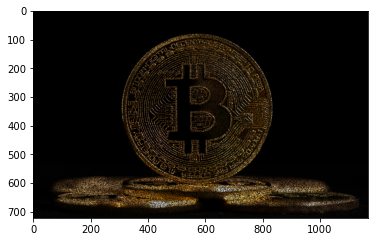

In [9]:
X_finish = np.zeros((image.shape[0], image.shape[1], 3))
X_finish[:,:,0] = X_red
X_finish[:,:,1] = X_blue
X_finish[:,:,2] = X_green
plt.imshow(X_finish)

Напишем функцию ADMM

In [10]:
Z = np.zeros((image.shape[0],image.shape[1]))
r = 1
def Update_ADMM(X, Z, l, Y_initial):
    l_new = l + r*(X - Z)
    U, S, V = np.linalg.svd(X, full_matrices=False) #V - выдаётся уже транспонированная
    X = Z - l_new / r - (U @ V) / r
    Z = X + l_new / r 
    Z[E==1] = Y_initial[E==1]
    print(np.sum(S))
    return X, Z, l_new

Пропустим ADMM алгоритм по кажому потоку и отследим значение нашей нормы(в данном случае она равна сумме элементов матрицы $\Sigma$:

In [11]:
steps = 50
lamda_1 = np.zeros((image.shape[0],image.shape[1]))
Z_1 = np.zeros((image.shape[0],image.shape[1]))
for step in tqdm(range(steps)):
    X_red, Z_1, lamda_1 = Update_ADMM(X_red, Z_1, lamda_1, Y_red)

  2%|▏         | 1/50 [00:00<00:14,  3.47it/s]

3167.832870123907


  4%|▍         | 2/50 [00:00<00:14,  3.39it/s]

3889.8328701239066


  6%|▌         | 3/50 [00:00<00:14,  3.34it/s]

7325.8604491514125


  8%|▊         | 4/50 [00:01<00:13,  3.34it/s]

2469.3132527675784


 10%|█         | 5/50 [00:01<00:13,  3.37it/s]

3298.7081617876793


 12%|█▏        | 6/50 [00:01<00:12,  3.39it/s]

2972.93489402265


 14%|█▍        | 7/50 [00:02<00:12,  3.50it/s]

3112.673407142454


 16%|█▌        | 8/50 [00:02<00:12,  3.36it/s]

2911.6720359074584


 18%|█▊        | 9/50 [00:02<00:12,  3.20it/s]

2997.6371813214528


 20%|██        | 10/50 [00:03<00:12,  3.14it/s]

2855.475366019859


 22%|██▏       | 11/50 [00:03<00:14,  2.64it/s]

2911.7458694796587


 24%|██▍       | 12/50 [00:03<00:13,  2.87it/s]

2804.134785991333


 26%|██▌       | 13/50 [00:04<00:12,  2.91it/s]

2841.7200088420823


 28%|██▊       | 14/50 [00:04<00:12,  2.97it/s]

2757.9727474244833


 30%|███       | 15/50 [00:05<00:14,  2.41it/s]

2783.6212281524868


 32%|███▏      | 16/50 [00:05<00:13,  2.58it/s]

2717.4812125711624


 34%|███▍      | 17/50 [00:05<00:11,  2.84it/s]

2735.6512613193413


 36%|███▌      | 18/50 [00:05<00:10,  3.06it/s]

2683.02091062419


 38%|███▊      | 19/50 [00:06<00:09,  3.17it/s]

2696.594252341074


 40%|████      | 20/50 [00:06<00:09,  3.19it/s]

2654.4382125607317


 42%|████▏     | 21/50 [00:06<00:10,  2.84it/s]

2665.2686498939333


 44%|████▍     | 22/50 [00:07<00:10,  2.61it/s]

2631.288706303893


 46%|████▌     | 23/50 [00:07<00:09,  2.83it/s]

2640.562709099243


 48%|████▊     | 24/50 [00:08<00:08,  3.00it/s]

2613.028329228434


 50%|█████     | 25/50 [00:08<00:09,  2.50it/s]

2621.5336383797326


 52%|█████▏    | 26/50 [00:08<00:09,  2.62it/s]

2599.1640256893766


 54%|█████▍    | 27/50 [00:09<00:08,  2.67it/s]

2607.44754986371


 56%|█████▌    | 28/50 [00:09<00:07,  2.88it/s]

2589.248848604018


 58%|█████▊    | 29/50 [00:09<00:07,  3.00it/s]

2597.6281320159783


 60%|██████    | 30/50 [00:10<00:06,  3.06it/s]

2582.761020655398


 62%|██████▏   | 31/50 [00:10<00:06,  2.99it/s]

2591.333259226605


 64%|██████▍   | 32/50 [00:10<00:05,  3.07it/s]

2579.06317850117


 66%|██████▌   | 33/50 [00:11<00:05,  3.10it/s]

2587.7697663969866


 68%|██████▊   | 34/50 [00:11<00:06,  2.60it/s]

2577.461553354483


 70%|███████   | 35/50 [00:12<00:05,  2.53it/s]

2586.1631491931676


 72%|███████▏  | 36/50 [00:12<00:06,  2.08it/s]

2577.2796674453093


 74%|███████▍  | 37/50 [00:13<00:06,  1.91it/s]

2585.8250287610404


 76%|███████▌  | 38/50 [00:13<00:05,  2.17it/s]

2577.9367227940493


 78%|███████▊  | 39/50 [00:14<00:05,  2.03it/s]

2586.218047404041


 80%|████████  | 40/50 [00:14<00:04,  2.03it/s]

2579.006441292784


 82%|████████▏ | 41/50 [00:15<00:04,  2.10it/s]

2586.975799520371


 84%|████████▍ | 42/50 [00:15<00:03,  2.37it/s]

2580.220481373235


 86%|████████▌ | 43/50 [00:15<00:02,  2.59it/s]

2587.876733352814


 88%|████████▊ | 44/50 [00:16<00:02,  2.83it/s]

2581.433694898607


 90%|█████████ | 45/50 [00:16<00:01,  2.97it/s]

2588.8001832284763


 92%|█████████▏| 46/50 [00:16<00:01,  3.00it/s]

2582.5786371909217


 94%|█████████▍| 47/50 [00:17<00:00,  3.06it/s]

2589.6855489693917


 96%|█████████▌| 48/50 [00:17<00:00,  3.01it/s]

2583.6293991318726


 98%|█████████▊| 49/50 [00:17<00:00,  2.93it/s]

2590.5052478366206


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]

2584.5805190668943


In [12]:
steps = 50
lamda_2 = np.zeros((image.shape[0],image.shape[1]))
Z_2 = np.zeros((image.shape[0],image.shape[1]))
for step in tqdm(range(steps)):
    X_blue, Z_2, lamda_2 = Update_ADMM(X_blue, Z_2, lamda_2, Y_blue)

  2%|▏         | 1/50 [00:00<00:15,  3.16it/s]

2428.92564367996


  4%|▍         | 2/50 [00:00<00:13,  3.56it/s]

3150.925643679959


  6%|▌         | 3/50 [00:00<00:13,  3.44it/s]

5878.708548657208


  8%|▊         | 4/50 [00:01<00:13,  3.43it/s]

1808.2501961143719


 10%|█         | 5/50 [00:01<00:13,  3.43it/s]

2700.924692503303


 12%|█▏        | 6/50 [00:01<00:13,  3.31it/s]

2348.880107828232


 14%|█▍        | 7/50 [00:02<00:12,  3.40it/s]

2561.0912654185486


 16%|█▌        | 8/50 [00:02<00:12,  3.48it/s]

2350.48604781366


 18%|█▊        | 9/50 [00:02<00:11,  3.45it/s]

2483.7869466800485


 20%|██        | 10/50 [00:02<00:11,  3.46it/s]

2338.52914593931


 22%|██▏       | 11/50 [00:03<00:10,  3.55it/s]

2430.508251983211


 24%|██▍       | 12/50 [00:03<00:11,  3.45it/s]

2323.041039280003


 26%|██▌       | 13/50 [00:03<00:10,  3.42it/s]

2389.7879191794323


 28%|██▊       | 14/50 [00:04<00:10,  3.46it/s]

2307.590710140532


 30%|███       | 15/50 [00:04<00:10,  3.47it/s]

2358.229542602046


 32%|███▏      | 16/50 [00:04<00:09,  3.42it/s]

2294.105019302213


 34%|███▍      | 17/50 [00:05<00:11,  2.79it/s]

2334.2286936384708


 36%|███▌      | 18/50 [00:05<00:10,  2.95it/s]

2283.460753474976


 38%|███▊      | 19/50 [00:05<00:10,  2.83it/s]

2316.533799827422


 40%|████      | 20/50 [00:06<00:12,  2.42it/s]

2275.8246743759973


 42%|████▏     | 21/50 [00:06<00:12,  2.40it/s]

2304.085590119115


 44%|████▍     | 22/50 [00:07<00:10,  2.60it/s]

2271.097492495881


 46%|████▌     | 23/50 [00:07<00:11,  2.38it/s]

2296.0040810495093


 48%|████▊     | 24/50 [00:07<00:10,  2.53it/s]

2268.9441123973425


 50%|█████     | 25/50 [00:08<00:09,  2.54it/s]

2291.371340528574


 52%|█████▏    | 26/50 [00:08<00:09,  2.51it/s]

2268.781156934451


 54%|█████▍    | 27/50 [00:09<00:08,  2.65it/s]

2289.2536506188158


 56%|█████▌    | 28/50 [00:09<00:08,  2.51it/s]

2269.9617340557643


 58%|█████▊    | 29/50 [00:09<00:08,  2.59it/s]

2288.807271798553


 60%|██████    | 30/50 [00:10<00:07,  2.58it/s]

2271.8904464201296


 62%|██████▏   | 31/50 [00:10<00:06,  2.75it/s]

2289.3303366067103


 64%|██████▍   | 32/50 [00:11<00:07,  2.45it/s]

2274.0884896219677


 66%|██████▌   | 33/50 [00:11<00:06,  2.54it/s]

2290.3028319885934


 68%|██████▊   | 34/50 [00:11<00:06,  2.66it/s]

2276.242055592815


 70%|███████   | 35/50 [00:12<00:05,  2.64it/s]

2291.4051828513498


 72%|███████▏  | 36/50 [00:12<00:04,  2.88it/s]

2278.203378650163


 74%|███████▍  | 37/50 [00:12<00:04,  3.05it/s]

2292.480918641886


 76%|███████▌  | 38/50 [00:13<00:04,  3.00it/s]

2279.935043155743


 78%|███████▊  | 39/50 [00:13<00:03,  3.07it/s]

2293.469120152441


 80%|████████  | 40/50 [00:13<00:03,  3.13it/s]

2281.4486467268953


 82%|████████▏ | 41/50 [00:14<00:02,  3.14it/s]

2294.3532762867235


 84%|████████▍ | 42/50 [00:14<00:02,  3.10it/s]

2282.770176304907


 86%|████████▌ | 43/50 [00:14<00:02,  2.50it/s]

2295.1351450464263


 88%|████████▊ | 44/50 [00:15<00:02,  2.76it/s]

2283.926647769632


 90%|█████████ | 45/50 [00:15<00:01,  2.71it/s]

2295.82337875499


 92%|█████████▏| 46/50 [00:15<00:01,  2.85it/s]

2284.9423401674176


 94%|█████████▍| 47/50 [00:16<00:01,  2.96it/s]

2296.4287313600485


 96%|█████████▌| 48/50 [00:16<00:00,  2.83it/s]

2285.8382294721423


 98%|█████████▊| 49/50 [00:17<00:00,  2.74it/s]

2296.9619924559975


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]

2286.632221830556


In [13]:
steps = 50
lamda_3 = np.zeros((image.shape[0],image.shape[1]))
Z_3 = np.zeros((image.shape[0],image.shape[1]))
for step in tqdm(range(steps)):
    X_green, Z_3, lamda_3 = Update_ADMM(X_green, Z_3, lamda_3, Y_green)

  2%|▏         | 1/50 [00:00<00:14,  3.33it/s]

1513.509086415673


  4%|▍         | 2/50 [00:00<00:14,  3.21it/s]

2235.5090864156728


  6%|▌         | 3/50 [00:00<00:14,  3.27it/s]

4110.578226843852


  8%|▊         | 4/50 [00:01<00:14,  3.17it/s]

1089.1674312513735


 10%|█         | 5/50 [00:01<00:13,  3.26it/s]

2090.4835739435184


 12%|█▏        | 6/50 [00:01<00:12,  3.41it/s]

1644.99547124365


 14%|█▍        | 7/50 [00:02<00:12,  3.36it/s]

1997.178385250684


 16%|█▌        | 8/50 [00:02<00:12,  3.36it/s]

1728.215830106296


 18%|█▊        | 9/50 [00:02<00:14,  2.93it/s]

1962.7894007173938


 20%|██        | 10/50 [00:03<00:13,  3.01it/s]

1774.3068970314214


 22%|██▏       | 11/50 [00:03<00:13,  2.96it/s]

1947.0073382890007


 24%|██▍       | 12/50 [00:03<00:12,  2.98it/s]

1803.0850060803273


 26%|██▌       | 13/50 [00:04<00:11,  3.12it/s]

1937.864653270799


 28%|██▊       | 14/50 [00:04<00:11,  3.21it/s]

1822.1823741682808


 30%|███       | 15/50 [00:04<00:11,  3.05it/s]

1932.1741552126819


 32%|███▏      | 16/50 [00:05<00:12,  2.80it/s]

1835.9874288392646


 34%|███▍      | 17/50 [00:05<00:12,  2.58it/s]

1929.0307672767615


 36%|███▌      | 18/50 [00:06<00:12,  2.48it/s]

1846.8227517111332


 38%|███▊      | 19/50 [00:06<00:11,  2.73it/s]

1927.7068909942893


 40%|████      | 20/50 [00:06<00:10,  2.93it/s]

1855.6439123260307


 42%|████▏     | 21/50 [00:06<00:09,  3.04it/s]

1927.3956034756652


 44%|████▍     | 22/50 [00:07<00:10,  2.68it/s]

1862.8523807630752


 46%|████▌     | 23/50 [00:07<00:09,  2.80it/s]

1927.5170381654564


 48%|████▊     | 24/50 [00:08<00:08,  2.98it/s]

1868.7326336081333


 50%|█████     | 25/50 [00:08<00:08,  3.11it/s]

1927.7724565670992


 52%|█████▏    | 26/50 [00:08<00:07,  3.17it/s]

1873.5328508163363


 54%|█████▍    | 27/50 [00:08<00:07,  3.19it/s]

1928.032124469602


 56%|█████▌    | 28/50 [00:09<00:06,  3.22it/s]

1877.464975161671


 58%|█████▊    | 29/50 [00:09<00:06,  3.26it/s]

1928.2486004891368


 60%|██████    | 30/50 [00:10<00:07,  2.69it/s]

1880.7081970336103


 62%|██████▏   | 31/50 [00:10<00:07,  2.56it/s]

1928.412155678439


 64%|██████▍   | 32/50 [00:10<00:06,  2.75it/s]

1883.4106166602182


 66%|██████▌   | 33/50 [00:11<00:06,  2.78it/s]

1928.5273557830556


 68%|██████▊   | 34/50 [00:11<00:06,  2.54it/s]

1885.690134650177


 70%|███████   | 35/50 [00:12<00:06,  2.23it/s]

1928.602231310623


 72%|███████▏  | 36/50 [00:12<00:06,  2.19it/s]

1887.637729598854


 74%|███████▍  | 37/50 [00:13<00:05,  2.35it/s]

1928.644520053236


 76%|███████▌  | 38/50 [00:13<00:05,  2.32it/s]

1889.3224144497426


 78%|███████▊  | 39/50 [00:13<00:04,  2.52it/s]

1928.660820277916


 80%|████████  | 40/50 [00:14<00:03,  2.70it/s]

1890.7962697615874


 82%|████████▏ | 41/50 [00:14<00:03,  2.88it/s]

1928.6565949771168


 84%|████████▍ | 42/50 [00:14<00:02,  2.94it/s]

1892.0987242015062


 86%|████████▌ | 43/50 [00:15<00:02,  2.96it/s]

1928.6363295064564


 88%|████████▊ | 44/50 [00:15<00:02,  2.98it/s]

1893.2598982777304


 90%|█████████ | 45/50 [00:15<00:01,  3.06it/s]

1928.6036838970883


 92%|█████████▏| 46/50 [00:15<00:01,  3.16it/s]

1894.3030995708896


 94%|█████████▍| 47/50 [00:16<00:00,  3.16it/s]

1928.5616250982428


 96%|█████████▌| 48/50 [00:16<00:00,  3.20it/s]

1895.2466343763476


 98%|█████████▊| 49/50 [00:16<00:00,  3.11it/s]

1928.512543658796


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]

1896.1051025558768


Видим, что наша теория работает, т.к норма наша сводится к минимуму. 
Теперь соединим обработанные потоки в 3D матрицу и получим восстановленной изображение:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


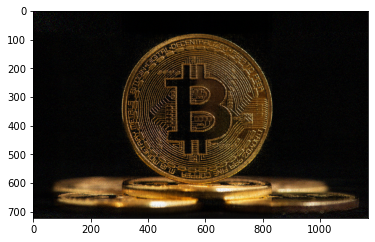

In [14]:
X_finish_new = np.zeros((image.shape[0], image.shape[1], 3))
X_finish_new[:,:,0] = X_red
X_finish_new[:,:,1] = X_blue
X_finish_new[:,:,2] = X_green
X_finish_new[X_finish_new < 0] = 0
plt.imshow(X_finish_new)